In [1]:
# Fetching stock data from tiingo API
# retrieving data pogramatically using python
# python requests package: python library to make requests
# Response: JSON format 
# API Key: dfeeb56a6c0e72a4c31667b48bfb938fc21c8163

In [3]:
import requests

In [4]:
# function for data request
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = 'https://api.tiingo.com/tiingo/daily/' + stock_symbol + '/prices'
    api_key = 'dfeeb56a6c0e72a4c31667b48bfb938fc21c8163'
    payload = {
        'token': api_key,
        'startDate': start_date,
        'endDate': end_date
    }
    # requests library makes URL with base URL and payload on it's own
    response = requests.get(base_url, params=payload)
    return response 

In [9]:
data_response = get_stock_data('AAPL', '2020-9-1', '2020-10-1')
print(data_response.url)
print(data_response.json())

https://api.tiingo.com/tiingo/daily/AAPL/prices?token=dfeeb56a6c0e72a4c31667b48bfb938fc21c8163&startDate=2020-9-1&endDate=2020-10-1
[{'date': '2020-09-01T00:00:00.000Z', 'close': 134.18, 'high': 134.8, 'low': 130.53, 'open': 132.76, 'volume': 152470142, 'adjClose': 133.9486454435, 'adjHigh': 134.567576433, 'adjLow': 130.3049388116, 'adjOpen': 132.5310938223, 'adjVolume': 152470142, 'divCash': 0.0, 'splitFactor': 1.0}, {'date': '2020-09-02T00:00:00.000Z', 'close': 131.4, 'high': 137.98, 'low': 127.0, 'open': 137.59, 'volume': 200118991, 'adjClose': 131.1734387485, 'adjHigh': 137.7420934438, 'adjLow': 126.7810252744, 'adjOpen': 137.3527658859, 'adjVolume': 200118991, 'divCash': 0.0, 'splitFactor': 1.0}, {'date': '2020-09-03T00:00:00.000Z', 'close': 120.88, 'high': 128.84, 'low': 120.5, 'open': 126.91, 'volume': 257599640, 'adjClose': 120.6715774423, 'adjHigh': 128.6178527272, 'adjLow': 120.2922326422, 'adjOpen': 126.6911804533, 'adjVolume': 257599640, 'divCash': 0.0, 'splitFactor': 1.0},

In [10]:
# parsing the data
# function to get only date, low, high from response
def decode_data(data_response):
    json_response = data_response.json()
    dates = []
    highs = []
    lows = []

    for json_object in json_response:
        date = json_object['date']
        high = json_object['high']
        low = json_object['low']
        
        dates.append(date)
        highs.append(high)
        lows.append(low)
    
    return dates, highs, lows

In [11]:
dates, highs, lows = decode_data(data_response)

In [12]:
print(dates)

['2020-09-01T00:00:00.000Z', '2020-09-02T00:00:00.000Z', '2020-09-03T00:00:00.000Z', '2020-09-04T00:00:00.000Z', '2020-09-08T00:00:00.000Z', '2020-09-09T00:00:00.000Z', '2020-09-10T00:00:00.000Z', '2020-09-11T00:00:00.000Z', '2020-09-14T00:00:00.000Z', '2020-09-15T00:00:00.000Z', '2020-09-16T00:00:00.000Z', '2020-09-17T00:00:00.000Z', '2020-09-18T00:00:00.000Z', '2020-09-21T00:00:00.000Z', '2020-09-22T00:00:00.000Z', '2020-09-23T00:00:00.000Z', '2020-09-24T00:00:00.000Z', '2020-09-25T00:00:00.000Z', '2020-09-28T00:00:00.000Z', '2020-09-29T00:00:00.000Z', '2020-09-30T00:00:00.000Z', '2020-10-01T00:00:00.000Z']


In [14]:
# graphing the data using pyplot
# prices vs dates
import matplotlib.pyplot as plt

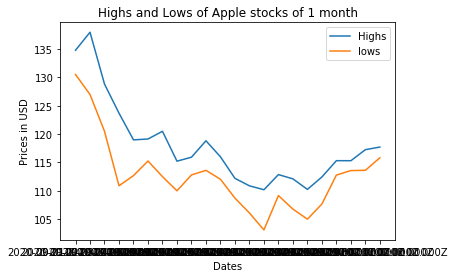

In [16]:
plt.plot(dates,highs, label='Highs')
plt.plot(dates,lows, label='lows')
plt.title('Highs and Lows of Apple stocks of 1 month')
plt.xlabel('Dates')
plt.ylabel('Prices in USD')
plt.legend(loc='upper right')
plt.show()